# 7장: 물류 네트워크 최적 설계를 위한 테크닉 10

## 61: 운송 최적화 문제 풀기

In [1]:
import warnings
warnings.filterwarnings('ignore')

pulp: 선형 계획법 모델링에 사용되는 라이브러리

In [2]:
!pip install pulp

ortoolpy: 선형 계획 문제를 보다 쉽게 처리하기 위해 제공되는 utility 함수 모음

In [3]:
!pip install ortoolpy

In [4]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

### 최적화 문제
: 어떤 목적함수의 결과값을 최적화시키는 파라미터의 조합을 찾는 문제
- 최적화 문제의 본질은 파라미터를 어느 방향으로 얼만큼 움직여서 함수 값을 최적화시킬 수 있을 것인지에 대한 것
- 조금씩 파라미터의 값과 위치를 변경해가며 더 이상 변경할 수 없는 지점에 도달할 수 있는 파라미터를 찾는 것
- local minima: 더 이상 최적화 시킬 수 없는 지점

In [5]:
#데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [6]:
df_tc.head()

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [7]:
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [8]:
df_supply.head()

,W1,W2,W3
0,35,41,42


In [9]:
#초기 설정
np.random.seed(1) #랜덤한 결과의 재현성 보장
nw = len(df_tc.index) #공장의 수
nf = len(df_tc.columns) #고객의 수
pr = list(product(range(nw), range(nf))) # 반환: (0,0), (0,1) 등 튜플들의 리스트
#product: 여러 개의 iterable에서 모든 가능한 조합 생성



#수리 모델 작성 (중요!!!)
# 목적함수 m1을 lpSum을 이용해 정의 목적함수 m1을 lpSum을 이용해 정의
m1 = model_min() #최소화를 실행하는 모델 m1 정의
v1 = {(i,j):LpVariable('v%d_%d'%(i,j), lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)

# 제약 조건을 m1에 정의
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

#총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


[수리모델 추가설명]
- LpVariable: 의사결정 변수 생성. 각 결정 변수에 대해 최소값(lowBound)과 최대값(upBound) 설정
- '%d_%d'%(i,j): 문자열 포매팅
    - 결과: i=2, j=3일 때 v2_3
- lpSum: 목적 함수 정의 (총 운송 비용)
    - 각 (i,j) 조합에 대해 (운송비용)*(운송량)을 모두 더한 것

## 62: 최적 운송 경로를 네트워크로 확인

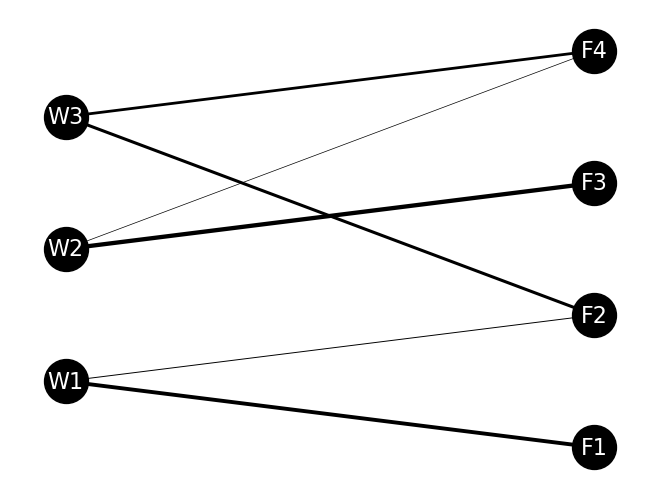

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

## 63: 최적 운송 경로가 제약 조건 만족하는지 확인

60번에서 작성한 제약 조건을 계산하는 함수를 이용해서 계산된 운송 경로가 제약 조건을 만족하는지 확인

In [11]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


## 64: 생산 계획 데이터 불러오기

물류 네트워크 전체에는 운송과 더불어 생산 계획도 중요한 요소

In [12]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


## 65: 이익 계산하는 함수 만들기

생산계획 최적화의 흐름 (최적화 문제의 일반적인 흐름과 동일)
1. 목적함수와 제약조건 정의
2. 제약 조건 아래서 목적함수를 최소화하는 변수의 조합 찾음
3. 이익을 계산할 함수 작성
4. 그것을 목적함수로 최대화

In [13]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("총 이익:" + str(product_plan(df_profit, df_plan)))

총 이익:80.0


## 66: 생산 최적화 문제 풀기

이익함수의 최대활르 목적으로 최적화 계산 진행

In [14]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

m = model_max() # '최대화' 계산 준비
v1 = {(i):LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:, i]
m.solve()

df_plan_sol = df_plan.copy()
for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:" + str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


## 67: 최적 생산 계획이 제약 조건 만족하는지 확인

(주의) 최적화 계산을 한 결과를 이해하지 않고 그냥 받아들이면 안됨
- 최적화 계산 결과를 '여러 가지 방법을 이용해서' 이해할 필요 있음

In [15]:
#제약 조건 계산 함수

def condition_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + "  사용량:" + str(temp_sum) + ", 재고:" + str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:" + str(condition_stock(df_plan_sol, df_material, df_stock)))

원료1  사용량:25.0, 재고:40.0
원료2  사용량:80.0, 재고:80.0
원료3  사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


## 68: 물류 네트워크 설계 문제 풀기

실제 물류 네트워크는 운송 경로와 생산 계획 최적화 문제를 동시에 고려해야 함
- 운송 비용과 제조 비용이 수요를 만족하면서 최소가 되게 정식화
- 목적함수: 운송 비용과 제조 비용의 함
- 제약조건: 각 대리점의 판매 수가 수요 수를 넘는 것으로 정의

In [21]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비 #
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요 #
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품), 
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)
print(tbdi2)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


- ortoolpy: Google의 OR-Tools 라이브러리를 쉽게 사용할 수 있도록 도와주는 Python 라이브러리
    - logistics_network: 물류 네트워크 최적화 문제를 쉽게 해결할 수 있도록 제공되는 함수
    - 여러 창고에서 여러 고객에게 물건을 배송할 때의 최적 경로 계산,
    - 공금지와 수요지 사이의 물류 비용을 최소화하려는 최적 네트워크 구축
    - 과 같은 문제들을 쉽게 풀 수 있게 도와줌

## 69: 최적 네트워크의 운송 비용과 그 내역 계산

In [22]:
tbdi2 = tbdi2[["공장","대리점","운송비","제품","VarX","ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000001,10.0
1,X,P,1,B,v000002,10.0
2,X,Q,3,A,v000003,10.0
3,X,Q,3,B,v000004,0.0
4,Y,P,2,A,v000005,0.0
5,Y,P,2,B,v000006,0.0
6,Y,Q,1,A,v000007,10.0
7,Y,Q,1,B,v000008,20.0


## 70: 최적 네트워크의 생산 비용과 그 내역 계산

In [23]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000009,20.0
3,X,1,B,0,inf,1.0,v000010,10.0
4,Y,0,A,0,10.0,3.0,v000011,10.0
6,Y,1,A,0,inf,5.0,v000012,0.0
7,Y,1,B,0,inf,3.0,v000013,20.0


In [24]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
print("총 생산비:" + str(product_cost))

총 생산비:120.0
